# Partial Differential Equations - Stefan problem

# s like surface, h like height and we are flying

### Finite difference method (try)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [459]:
def lambd_gen(dx, dt, b=False):
    return dt/(2*(dx**2)) if not b else -dt/(2*(dx**2))

def generate_matrix(dx, dt, M = 10, b=False):
    lambd = lambd_gen(dx, dt, b)
    A = np.zeros((M-1, M-1))
    for i in range(M-1):
        A[i][i] = 1 - 2*lambd
        if 1 <= i < M-1:
            A[i-1][i] = lambd
        if 0 <= i < M-2:
            A[i+1][i] = lambd
    return A

def finite_diff(dx=2, dt=1, M=10):
    u = [0.5]*(M-1)
    u[0] = 0
    u = np.array(u)
    result = np.zeros((M-1, M-1))
    result[0] = u
    A = generate_matrix(dx, dt, M)
    B = generate_matrix(dx, dt, M, True)
    for i in range(1, M-1):
        new_u = np.linalg.inv(B) @ A @ u
        result[i] = new_u
        u = new_u
    return result

def gen_matrixA(M):
    A = np.zeros((M-1, M-1))
    for i in range(M-1):
        A[i][i] = -2
        if 1 <= i < M-1:
            A[i-1][i] = 1
        if 0 <= i < M-2:
            A[i+1][i] = 1
    return A

def gen_matrixB(xs):
    M = len(xs)
    B = np.zeros((M, M))
    for i in range(M):
        if 1 <= i < M:
            B[i-1][i] = xs[i-1]
        if 0 <= i < M-1:
            B[i+1][i] = -xs[i+1]
    return B

def quartic(x, t, F_new, F_old, M, beta, dt, dx, ksi, s):
    r = dt/dx**2
    v = dt/dx
    return (2*r*(t[1]+t[0])*(F_new[M-1]+F_old[M-1]))-(4*beta/v)*(r+((ksi[M]/(4*dx))*(x**2-s[0]**2)))*(x**2-s[0]**2)

def quartic_prim(x, h, t, F_new, F_old, M, beta, dt, dx, ksi, s):
    return (quartic(x+h, t, F_new, F_old, M, beta, dt, dx, ksi, s) \
            - quartic(x, t, F_new, F_old, M, beta, dt, dx, ksi, s)) / h

def newton_czy(x, h, t, F_new, F_old, M, beta, dt, dx, ksi, epsilon, s):
    step = 0
    while step < 10**6:
        new_x = x - quartic(x, t, F_new, F_old, M, beta, dt, dx, ksi, s) \
        / quartic_prim(x, h, t, F_new, F_old, M, beta, dt, dx, ksi, s)
        new_x = abs(new_x)
        #if abs(x - new_x) < epsilon:
        q = quartic(new_x, t, F_new, F_old, M, beta, dt, dx, ksi, s)
        if abs(q) < epsilon:
            return new_x
        x = new_x
        step += 1
    return x

def finite_difference_method(t_max, dt, beta=1, M=10):
    ts = np.arange(0, t_max+dt, 1)*dt
    N = len(ts)
    ksi = np.linspace(0, 1, M+1)
    dx = ksi[1] - ksi[0]
    gamma = 1/np.sqrt(beta)
    s = [0, 0] ###NEWTON 3

    A = 1/(2*dx**2)*gen_matrixA(M+1)
    B = 1/(4*dx)*gen_matrixB(ksi[1:])
    I = np.identity(M)
    
    f = 1 - ksi
    
    result = np.zeros((N, M+1))
    result[0] = f
    st = np.zeros(N)
    old_f = f[1:]
    
    for i in range(1, N):
        tn_12 = (ts[i]+ts[i-1])/2
        sn_12 = (s[1] + s[0])/2
        sp = (s[1] - s[0])/dt
        
        L = tn_12*A - sn_12**2 * (0.5 + tn_12/dt)*I + tn_12*sn_12*sp*B
        R = -tn_12*A + sn_12**2 * (0.5 - tn_12/dt)*I - tn_12*sn_12*sp*B
        D = np.zeros(M)
        if i == 1:
            D[0] = -(tn_12/(2*dx**2) + (ksi[1]*tn_12*sn_12*(s[1]-s[0])/dt)/(4*dx))*((np.exp(ts[i])-1)/ts[i] + 1)
        else:
            D[0] = -(tn_12/(2*dx**2) + (ksi[1]*tn_12*sn_12*(s[1]-s[0])/dt)/(4*dx))*((np.exp(ts[i])-1)/ts[i] \
                                                                                   + (np.exp(ts[i-1])-1)/(ts[i-1]))
        new_f = np.linalg.inv(L) @ (R @ old_f + D)
        s_new = newton_czy(s[1], 10**(-4), [ts[i],ts[i-1]], new_f, old_f, M, beta, dt, dx, ksi, 10**(-2), s)
        #s = [s_new, s_new]
        s = [s[1], s_new]
        st[i] = s_new
        f[0] = (np.exp(ts[i])-1)/ts[i] + (np.exp(ts[i-1])-1)/(ts[i-1]) - f[0] if i > 1 else 1
        f[1:] = new_f
        f[-1] = 0
        U = f*ts[i]
        result[i] = U
        old_f = new_f
    return result, st

In [465]:
def anal_sol(t_max, dt, beta, M = 10):
    ts = np.arange(0, t_max+dt, 1)*dt
    ksi = np.linspace(0, 1, M+1)
    gamma = 1/np.sqrt(beta)
    s_anal = np.zeros(len(ts))
    U_anal = [0]*len(ts)
    for i in range(1, len(ts)):
        s_anal[i] = gamma*ts[i]
        U_anal[i] = np.exp(ts[i] - s_anal[i] * ksi) - beta
    return U_anal, s_anal

In [466]:
t = 10
dt = 0.1
beta = 2
M1 = 10
M2 = 100

In [467]:
anal = anal_sol(t, dt, beta, M2)

In [468]:
fdm = finite_difference_method(t, dt, beta, M1)

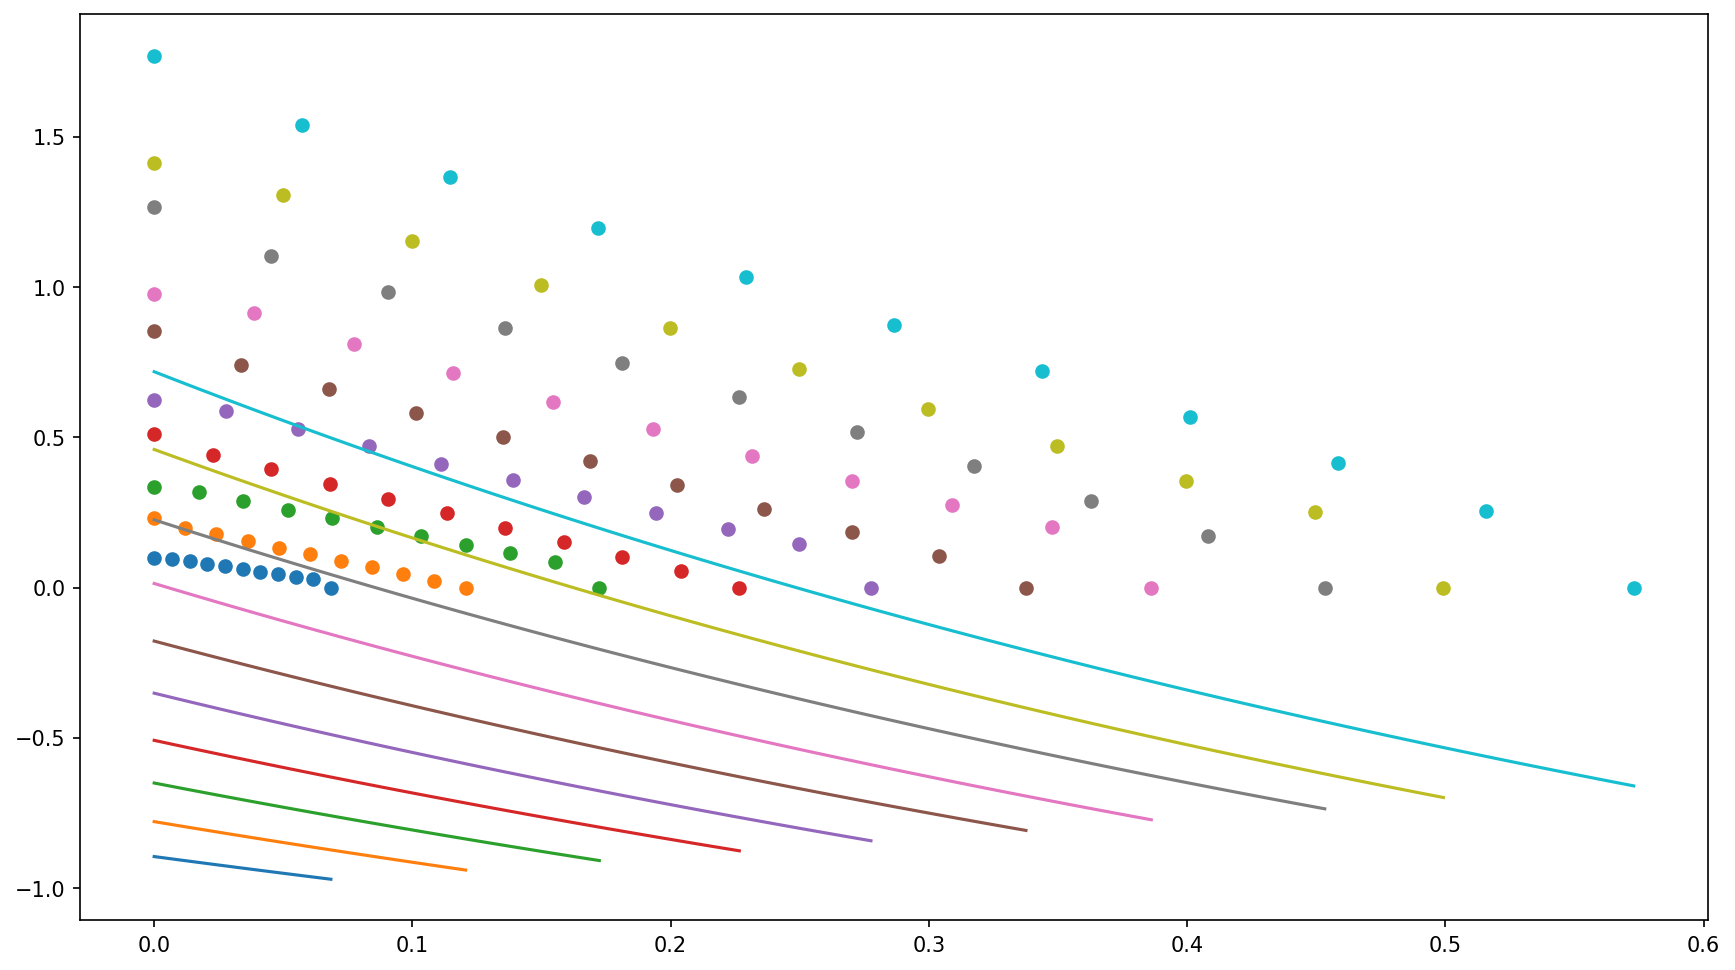

In [469]:
plt.figure(figsize = (14, 8), dpi = 150)
ksi2 = np.linspace(0, 1, M2 + 1)
ksi1 = np.linspace(0, 1, M1 + 1)
for i in range(1, len(anal[0])):
    plt.plot(ksi2*fdm[1][i], anal[0][i])
for i in range(1, len(fdm[0])):
    plt.scatter(ksi1*fdm[1][i], fdm[0][i])

In [454]:
fdm[1]

array([0.        , 0.13640594, 0.27558765, 0.40845911, 0.55503696,
       0.68482282, 0.83043275, 0.9627645 , 1.10717479, 1.24155497,
       1.38413935])

ValueError: x and y must be the same size

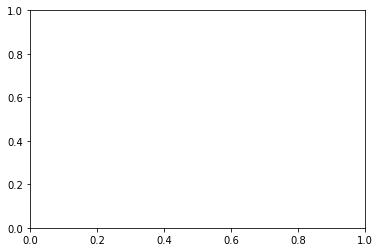

In [408]:
ksi = np.linspace(0, 1, 101)
for i in range(1, len(fdm[0])):
    plt.scatter(ksi*fdm[1][i], fdm[0][i])

In [66]:
xc[0] = [1, 2, 4, 5, 6]

## useful

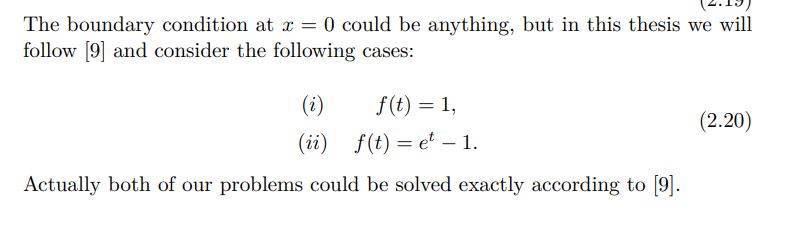

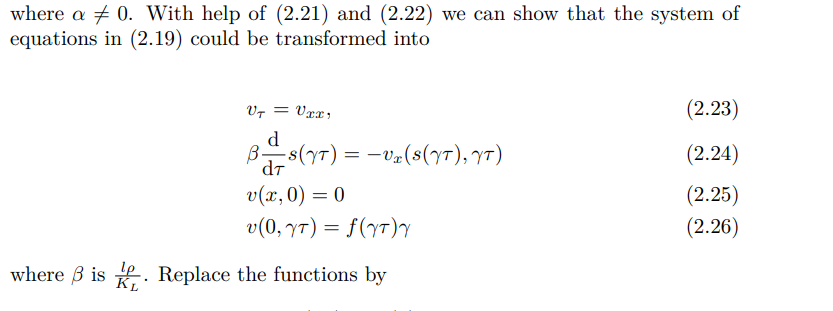

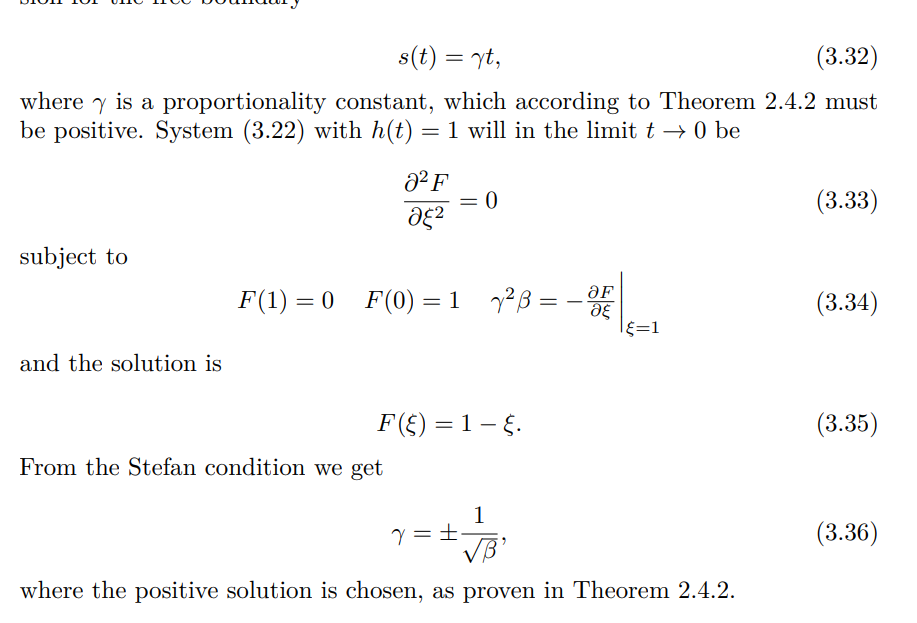

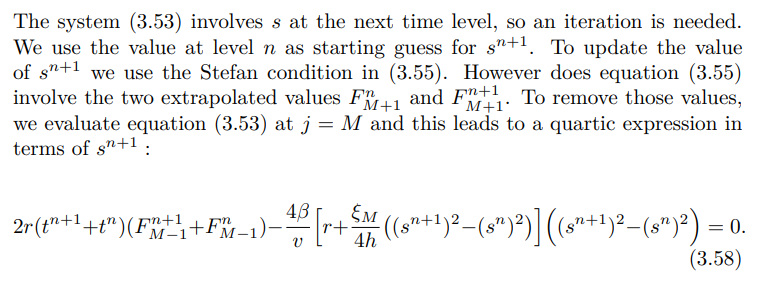

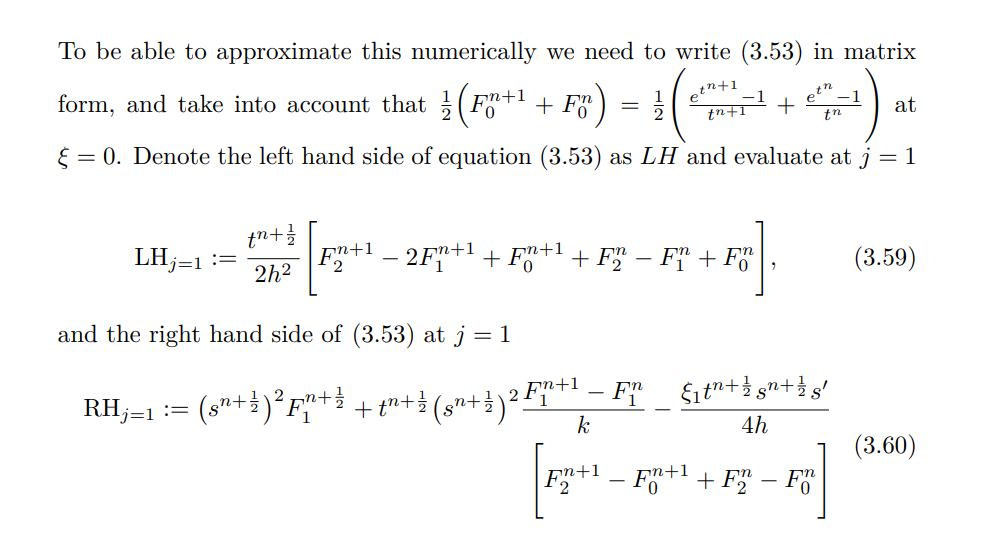